# 准备数据
`qwen-squad.pkl`

```
{
	"meta": {
		"model": "qwen",
		"dataset": "squad"
	},
	"data": [{
		"example": {
			"id": "id1",
			"question": "q1",
			"context": "c1",
			"answers": ["a1"]
		},
		"golden": {
			"greedy_response": "gready_text",
			"tbg_emb": Tensor(),
			"slt_emb": Tensor(),
			"sample_responses": ["response1","response2"],
			"cluster_ids": [0,1],
			"entropy": 1.5,
			"accuracy_qwen": 1.0,
			"accuracy_gpt": 1.0,
		},
		"irrelevant": {},
		"without": {},
	}]
}

```

```
{
	"dataset": "squad",
	"gen_model": "qwen",
	"example_id": "1",
	"response": "xxxxxx",
	"eval_model": "gpt-4o",
	"eval_prompt": "",
	"eval_id": "xxxx",
	"eval_response": "",
}

eval结果字典：
{"$eval_id": "$eval_result"}
eval结果数组
[{"$eval_id", "$eval_result"}]
```

In [1]:
%load_ext autoreload
%autoreload 2

import json
import warnings
import os
import pickle
from tqdm import tqdm
import torch
from collections import defaultdict, Counter
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from core.computation.uncertainty_measure import cluster_assignment_entropy

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)


def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            it = {}
            it['text'] = r['text']
            it['slt_emb'] = r['hidden_states']['sec_last_token_embedding']
            it['tbg_emb'] = r['hidden_states']['last_tok_bef_gen_embedding']
            responses.append(it)
    return responses

def load_greedy_response(generation_file_path):
    responses = load_responses(generation_file_path)
    assert len(responses) <= 1, f"More than one response found in {generation_file_path}."
    return responses[0] if len(responses) == 1 else None

def load_sample_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            responses.append(r['text'])
    return responses

def load_qwen_accuracy(eval_file_path):
    accuracy = []
    if os.path.exists(eval_file_path):
        res = load_pickle_file(eval_file_path)
        accuracy = res.get('qwen_scores', [])
    return accuracy[0] if len(accuracy) == 1 else None

def load_cluster_ids(clustered_file_path):
    cluster_ids = []
    if os.path.exists(clustered_file_path):
        res = load_pickle_file(clustered_file_path)
        cluster_ids = res.get('cluster_ids', [])
    return cluster_ids

# 计算语义熵
def compute_entropy(cluster_ids):
    if len(cluster_ids) == 0:
        return -1
    return cluster_assignment_entropy(cluster_ids)

In [2]:
def quick_look_data(model_name, dataset_json_file, dataset_name):
    assert os.path.exists(dataset_json_file), f"Dataset json file {dataset_json_file} not found."
    id_list, data_dict = load_ds_from_json(dataset_json_file)
    
    print(f"dataset: {dataset_name}")

    greedy_response_count = defaultdict(int)
    stat = defaultdict(Counter)
    for i, example_id in enumerate(tqdm(id_list, desc=f"Quick Looking")):
        assert example_id in data_dict, f"Example id {example_id} not found in dataset {dataset_json_file}."
        example = data_dict[example_id]
        example_result = {}
        example_result['example'] = example

        for context_type in ["golden", "irrelevant", "without"]:
            context_result = {}

            # greedy
            greedy_gen_path = f"output/train/generation/{model_name}/{dataset_name}/greedy_{context_type}/{example_id}.pkl"

            if not os.path.exists(greedy_gen_path):
                continue
            greedy_dict = load_greedy_response(greedy_gen_path)
            if not greedy_dict:
                continue
            context_result['greedy_response'] = greedy_dict['text']
            if len(context_result['greedy_response']) > 0:
                greedy_response_count[context_type] += 1
            context_result['tbg_emb'] = greedy_dict['tbg_emb']
            context_result['slt_emb'] = greedy_dict['slt_emb']

            # accuracy，可能为None
            eval_path = f"output/train/evaluation/{model_name}/{dataset_name}/greedy_{context_type}/{example_id}.pkl"
            acc_qwen = load_qwen_accuracy(eval_path)
            context_result['accuracy_qwen'] = acc_qwen # 可能为None

            # sample
            sample_gen_path = f"output/train/generation/{model_name}/{dataset_name}/sample_{context_type}/{example_id}.pkl"
            sample_responses = load_sample_responses(sample_gen_path)
            context_result['sample_responses'] = sample_responses

            # cluster_ids，可能为None
            cluster_path = f"output/train/clustered/{model_name}/{dataset_name}/sample_{context_type}/{example_id}.pkl"
            cluster_ids = load_cluster_ids(cluster_path)
            key = f"{len(sample_responses)} - {len(cluster_ids)})"
            stat[context_type][key] += 1
            if len(cluster_ids) != len(sample_responses):
                cluster_ids = None
            context_result['cluster_ids'] = cluster_ids

            # entropy，可能为None
            if cluster_ids is None:
                entropy = None
            else:
                entropy = compute_entropy(cluster_ids)
            context_result['entropy'] = entropy

            example_result[context_type] = context_result
    for context_type in ["golden", "irrelevant", "without"]:
        print(f"{context_type} stat: {stat[context_type]}")
    print(f"greedy_response_count: {greedy_response_count}")

quick_look_data(model_name="Qwen/Qwen2.5-7B-Instruct", dataset_json_file="dataset/json/squad_train_2000.json", dataset_name="squad")
quick_look_data(model_name="Qwen/Qwen2.5-7B-Instruct", dataset_json_file="dataset/json/triviaqa_train_2000.json", dataset_name="triviaqa")
quick_look_data(model_name="Qwen/Qwen2.5-7B-Instruct", dataset_json_file="dataset/json/bioasq_train_2000.json", dataset_name="bioasq")

dataset: squad


Quick Looking: 100%|██████████| 2000/2000 [00:14<00:00, 135.48it/s]


golden stat: Counter({'30 - 30)': 2000})
irrelevant stat: Counter({'30 - 30)': 2000})
without stat: Counter({'30 - 30)': 2000})
greedy_response_count: defaultdict(<class 'int'>, {'golden': 2000, 'irrelevant': 1998, 'without': 2000})
dataset: triviaqa


Quick Looking: 100%|██████████| 2000/2000 [00:14<00:00, 134.81it/s]


golden stat: Counter({'30 - 30)': 2000})
irrelevant stat: Counter({'30 - 30)': 1999})
without stat: Counter({'30 - 30)': 2000})
greedy_response_count: defaultdict(<class 'int'>, {'golden': 1999, 'irrelevant': 1998, 'without': 2000})
dataset: bioasq


Quick Looking: 100%|██████████| 2000/2000 [00:14<00:00, 136.50it/s]

golden stat: Counter({'30 - 30)': 2000})
irrelevant stat: Counter({'30 - 30)': 2000})
without stat: Counter({'30 - 30)': 2000})
greedy_response_count: defaultdict(<class 'int'>, {'golden': 1998, 'irrelevant': 1998, 'without': 2000})


In [3]:
def make_data(model_name, dataset_json_file, dataset_name):
    assert os.path.exists(dataset_json_file), f"Dataset json file {dataset_json_file} not found."
    id_list, data_dict = load_ds_from_json(dataset_json_file)

    final_data = []

    for i, example_id in enumerate(tqdm(id_list, desc=f"Preparing")):
        assert example_id in data_dict, f"Example id {example_id} not found in dataset {dataset_json_file}."
        example = data_dict[example_id]
        example_result = {}
        example_result['example'] = example

        for context_type in ["golden", "irrelevant", "without"]:
            context_result = {}

            # greedy
            greedy_gen_path = f"output/train/generation/{model_name}/{dataset_name}/greedy_{context_type}/{example_id}.pkl"

            if not os.path.exists(greedy_gen_path):
                continue
            greedy_dict = load_greedy_response(greedy_gen_path)
            if not greedy_dict:
                continue
            context_result['greedy_response'] = greedy_dict['text']
            if len(context_result['greedy_response']) <= 0:
                continue
            context_result['tbg_emb'] = greedy_dict['tbg_emb']
            context_result['slt_emb'] = greedy_dict['slt_emb']

            # accuracy，可能为None
            eval_path = f"output/train/evaluation/{model_name}/{dataset_name}/greedy_{context_type}/{example_id}.pkl"
            acc_qwen = load_qwen_accuracy(eval_path)
            context_result['accuracy_qwen'] = acc_qwen # 可能为None

            # sample
            sample_gen_path = f"output/train/generation/{model_name}/{dataset_name}/sample_{context_type}/{example_id}.pkl"
            sample_responses = load_sample_responses(sample_gen_path)
            context_result['sample_responses'] = sample_responses

            # cluster_ids，可能为None
            cluster_path = f"output/train/clustered/{model_name}/{dataset_name}/sample_{context_type}/{example_id}.pkl"
            cluster_ids = load_cluster_ids(cluster_path)
            if len(cluster_ids) != len(sample_responses):
                cluster_ids = None
            context_result['cluster_ids'] = cluster_ids

            # entropy，可能为None
            if cluster_ids is None:
                entropy = None
            else:
                entropy = compute_entropy(cluster_ids)
            context_result['entropy'] = entropy

            example_result[context_type] = context_result
        final_data.append(example_result)
    return {
        "meta": {
            "model": model_name,
            "dataset": dataset_name,
            "dataset_json_file": dataset_json_file,
        },
        "data": final_data,
    }


def make_all_data():
    datasets = [
        ("squad", "dataset/json/squad_train_2000.json", "output/data/qwen-squad.pkl"), 
        ("triviaqa", "dataset/json/triviaqa_train_2000.json", "output/data/qwen-triviaqa.pkl"), 
        ("bioasq", "dataset/json/bioasq_train_2000.json", "output/data/qwen-bioasq.pkl")]
    model_name = "Qwen/Qwen2.5-7B-Instruct"
    for dataset_name, dataset_json_file, output_file in datasets:
        print(f"Processing dataset {dataset_name}...")
        data = make_data(model_name, dataset_json_file, dataset_name)
        save_pickle_file(output_file, data)

%time make_all_data()

Processing dataset squad...


Preparing: 100%|██████████| 2000/2000 [00:16<00:00, 123.17it/s]


Processing dataset triviaqa...


Preparing: 100%|██████████| 2000/2000 [00:15<00:00, 126.45it/s]


Processing dataset bioasq...


Preparing: 100%|██████████| 2000/2000 [00:15<00:00, 132.26it/s]


CPU times: user 46.5 s, sys: 12.7 s, total: 59.2 s
Wall time: 59 s


In [4]:
# 将数据中的tensor值替换为shape，不改变原值
def tensor_to_shape(data):
    if isinstance(data, torch.Tensor):
        return f"Tensor{tuple(data.shape)}"
    elif isinstance(data, dict):
        return {k: tensor_to_shape(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [tensor_to_shape(v) for v in data]
    else:
        return data
    
# 检查数据是否完整
def check_item(item):
    for context_type in ["golden", "irrelevant", "without"]:
        if context_type not in item:
            return False
        context = item[context_type]
        if context.get("tbg_emb", None) is None:
            return False
        if context.get("slt_emb", None) is None:
            return False
        if context.get("greedy_response", None) is None:
            return False
        if context.get("sample_responses", None) is None:
            return False
        if context.get("cluster_ids", None) is None:
            return False
        if context.get("entropy", None) is None:
            return False
        if context.get("accuracy_qwen", None) is None:
            return False
        if len(context["sample_responses"]) != len(context["cluster_ids"]):
            return False
    
    return True

# 检查数据
def check_data(data):
    valid_data = []
    invalid_data = []
    for item in tqdm(data, desc="Checking"):
        if check_item(item):
            valid_data.append(item)
        else:
            invalid_data.append(item)
    print(f"Valid: {len(valid_data)}, Invalid: {len(invalid_data)}")
    return valid_data, invalid_data

# 可视化sample_responses个数
def vis_sample_responses(data, title):
    counts = defaultdict(Counter)
    for item in data:
        for context_type in ["golden", "irrelevant", "without"]:
            context = item[context_type]
            counts[context_type][len(context["sample_responses"])] += 1

    for context_type, counts in counts.items():
        title1 = f"{title} - {context_type}"
        print(f"{title1}: {counts.most_common(10)}")
        plt.hist(counts.keys(), weights=counts.values())
        plt.xlabel("#sample responses")
        plt.ylabel("Count")
        plt.title(title1)
        plt.show()

# 简化模型名称
def short_model_name(model_name):
    if 'qwen' in model_name.lower():
        return 'qwen'
    elif 'llama' in model_name.lower():
        return 'llama'
    return model_name.split("/")[-1]

# 可视化聚簇数量
def vis_cluster_ids(data, title):
    counts = defaultdict(Counter)
    for item in data:
        for context_type in ["golden", "irrelevant", "without"]:
            context = item[context_type]
            counts[context_type][len(set(context['cluster_ids']))] += 1

    for context_type, counts in counts.items():
        title1 = f"{title} - {context_type}"
        print(f"{title1}: {counts.most_common(10)}")
        plt.hist(counts.keys(), weights=counts.values())
        plt.xlabel("#clusters")
        plt.ylabel("Count")
        plt.title(title1)
        plt.show()

# 可视化entropy
def vis_entropy(data, title):
    entropies = defaultdict(Counter)
    for item in data:
        for context_type in ["golden", "irrelevant", "without"]:
            context = item[context_type]
            if context['entropy'] is not None:
                entropies[context_type][context['entropy']] += 1

    for context_type, counts in entropies.items():
        title1 = f"{title} - {context_type}"
        print(f"{title1}: {counts.most_common(10)}")
        plt.hist(counts.keys(), weights=counts.values())
        plt.xlabel("Entropy")
        plt.ylabel("Count")
        plt.title(title1)
        plt.show()

# 可视化accuracy
def vis_accuracy(data, title):
    accuracies = defaultdict(Counter)
    for item in data:
        for context_type in ["golden", "irrelevant", "without"]:
            context = item[context_type]
            if context['accuracy_qwen'] is not None:
                accuracies[context_type][context['accuracy_qwen']] += 1

    for context_type, counts in accuracies.items():
        title1 = f"{title} - {context_type}"
        print(f"{title1}: {counts.most_common(10)}")
        plt.hist(counts.keys(), weights=counts.values())
        plt.xlabel("Accuracy")
        plt.ylabel("Count")
        plt.title(title1)
        plt.show()

def print_data_info(data):
    # 打印meta信息
    print(f"Meta: \n{json.dumps(data['meta'], indent=2)}")
    # 总数
    print(f"Total items: {len(data['data'])}")
    # 检查数据
    valid_data, invalid_data = check_data(data['data'])
    if len(valid_data) <= 0:
        print("No valid data found.")
        return
    # 打印第一个data的信息
    print(f"First item: \n{json.dumps(tensor_to_shape(valid_data[0]), indent=2)}")
    # 可视化sample_responses个数
    vis_sample_responses(valid_data, f"{short_model_name(data['meta']['model'])} - {data['meta']['dataset']}")
    # 可视化聚簇数量
    vis_cluster_ids(valid_data, f"{short_model_name(data['meta']['model'])} - {data['meta']['dataset']}")
    # 可视化entropy
    vis_entropy(valid_data, f"{short_model_name(data['meta']['model'])} - {data['meta']['dataset']}")
    # 可视化accuracy
    vis_accuracy(valid_data, f"{short_model_name(data['meta']['model'])} - {data['meta']['dataset']}")

Meta: 
{
  "model": "Qwen/Qwen2.5-7B-Instruct",
  "dataset": "squad",
  "dataset_json_file": "dataset/json/squad_train_2000.json"
}
Total items: 2000


Checking: 100%|██████████| 2000/2000 [00:00<00:00, 266949.08it/s]

Valid: 1998, Invalid: 2
First item: 
{
  "example": {
    "id": "57313c0a497a881900248cae",
    "question": "How were pigments like red lake created?",
    "context": "Unlike vermilion or red ochre, made from minerals, red lake pigments are made by mixing organic dyes, made from insects or plants, with white chalk or alum. Red lac was made from the gum lac, the dark red resinous substance secreted by various scale insects, particularly the Laccifer lacca from India. Carmine lake was made from the cochineal insect from Central and South America, Kermes lake came from a different scale insect, kermes vermilio, which thrived on oak trees around the Mediterranean. Other red lakes were made from the rose madder plant and from the brazilwood tree.",
    "answers": [
      "mixing organic dyes"
    ],
    "irrelevant_id": "57268318708984140094c88b",
    "irrelevant_context": "One of the paper's best known front pages, published on 4 May 1982, commemorated the torpedoing of the Argentine ship 

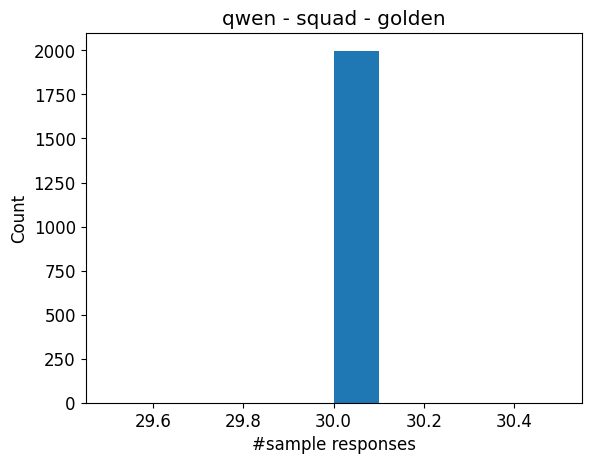

qwen - squad - irrelevant: [(30, 1998)]


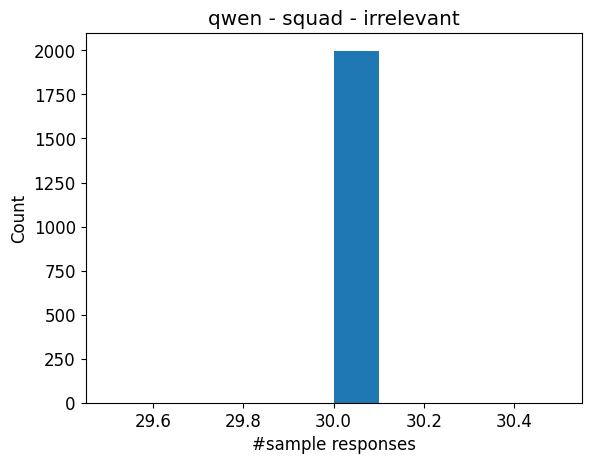

qwen - squad - without: [(30, 1998)]


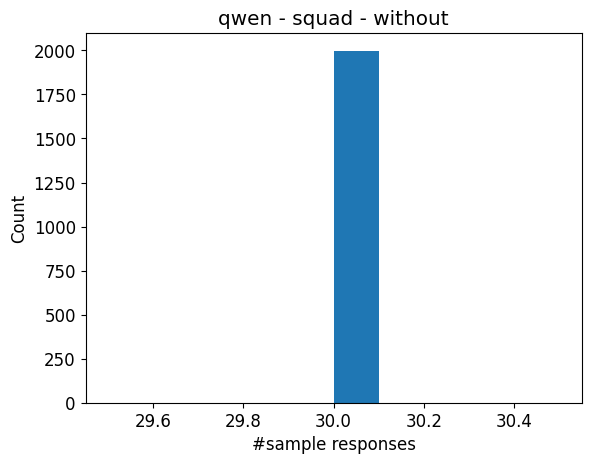

qwen - squad - golden: [(1, 1707), (2, 135), (3, 68), (4, 24), (5, 19), (6, 18), (7, 8), (8, 6), (9, 4), (10, 4)]


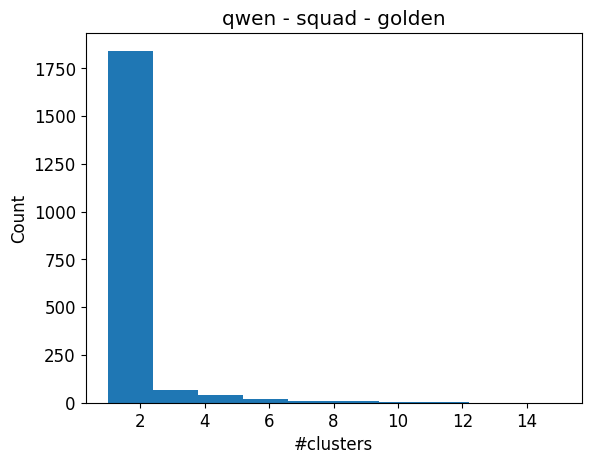

qwen - squad - irrelevant: [(4, 240), (5, 198), (3, 182), (6, 179), (7, 175), (8, 172), (1, 171), (2, 149), (9, 124), (10, 88)]


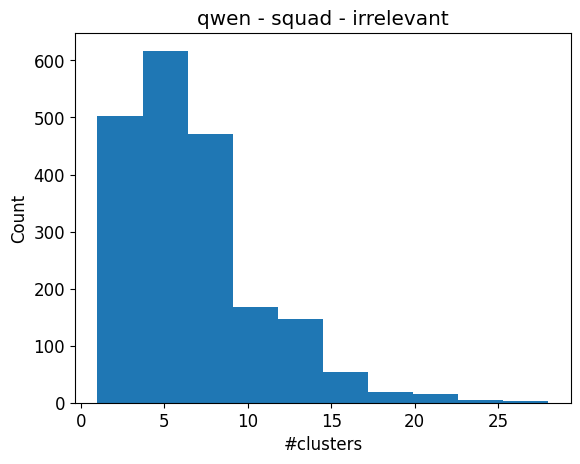

qwen - squad - without: [(1, 546), (2, 304), (3, 217), (4, 136), (5, 124), (6, 111), (7, 96), (8, 71), (9, 57), (12, 46)]


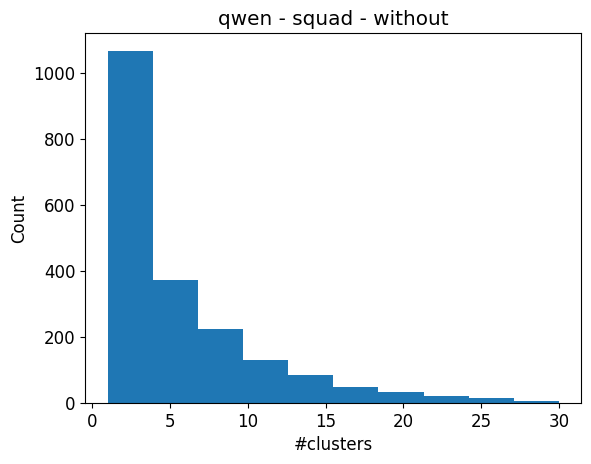

qwen - squad - golden: [(-0.0, 1707), (0.6842317651303003, 17), (0.24493002679463532, 12), (0.1461447460085638, 12), (0.6571577614973405, 11), (0.39267446722755217, 10), (0.3250829733914482, 10), (0.5432727813369008, 10), (0.6365141682948128, 8), (0.6108643020548934, 8)]


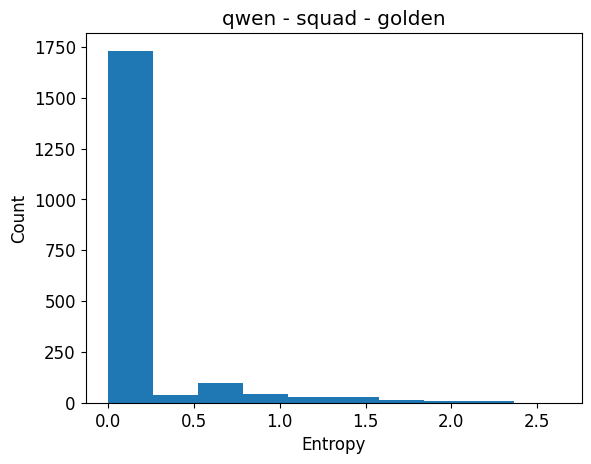

qwen - squad - irrelevant: [(-0.0, 171), (0.1461447460085638, 24), (0.24493002679463532, 18), (0.3250829733914482, 17), (0.45056120886630463, 12), (0.6571577614973405, 11), (0.6730116670092565, 10), (0.5432727813369008, 10), (0.39267446722755217, 8), (0.6842317651303003, 7)]


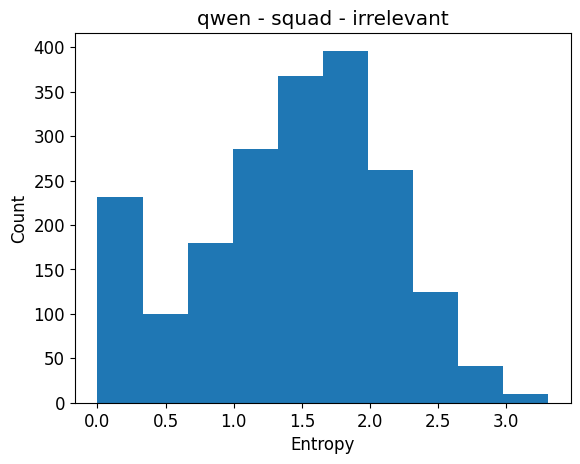

qwen - squad - without: [(-0.0, 546), (0.3250829733914482, 29), (0.6571577614973405, 26), (0.6365141682948128, 24), (0.5799151714181009, 23), (0.39267446722755217, 23), (0.45056120886630463, 22), (0.5432727813369008, 21), (0.24493002679463532, 20), (0.5004024235381879, 19)]


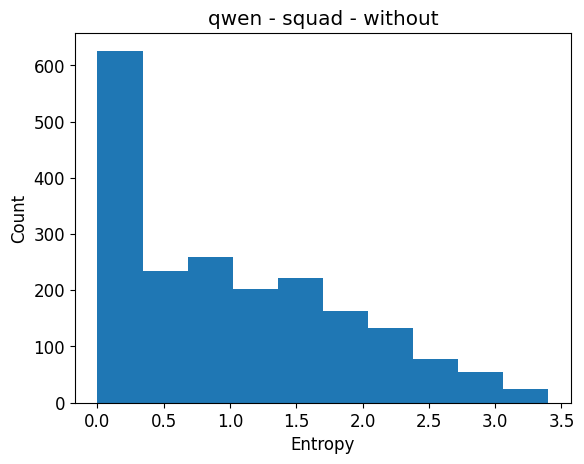

qwen - squad - golden: [(1.0, 1750), (0.0, 248)]


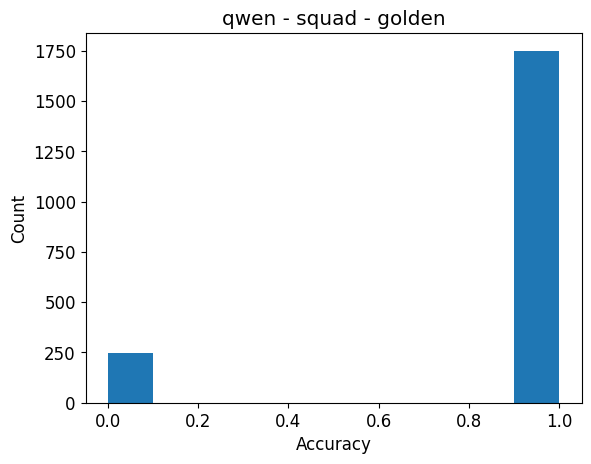

qwen - squad - irrelevant: [(0.0, 1778), (1.0, 220)]


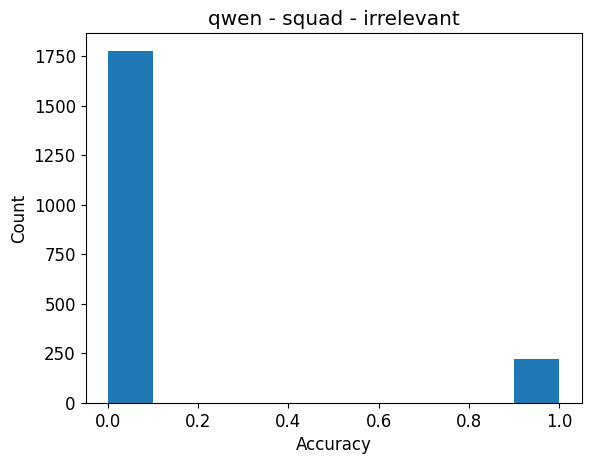

qwen - squad - without: [(0.0, 1480), (1.0, 518)]


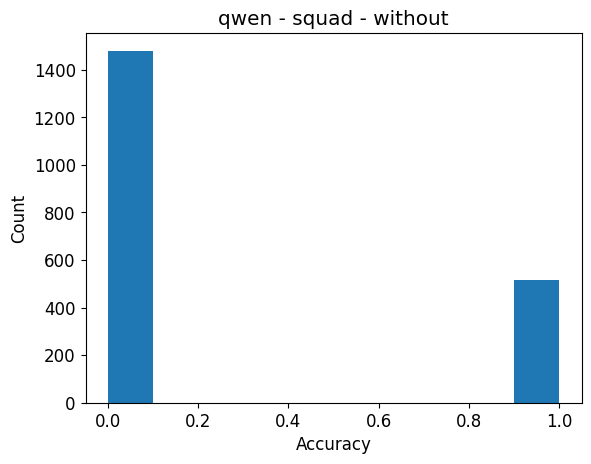

In [5]:
data = load_pickle_file("output/data/qwen-squad.pkl")
print_data_info(data)

Meta: 
{
  "model": "Qwen/Qwen2.5-7B-Instruct",
  "dataset": "triviaqa",
  "dataset_json_file": "dataset/json/triviaqa_train_2000.json"
}
Total items: 2000


Checking: 100%|██████████| 2000/2000 [00:00<00:00, 265168.58it/s]

Valid: 1997, Invalid: 3
First item: 
{
  "example": {
    "id": "240572717870847160091849199767134743149",
    "origin_id": "qw_5633--35/35_234122.txt#0_0",
    "question": "Mallard, Mandarin, Red-crested Pochard, Teal, Muscovy and Eider are all types of what?",
    "context": "May 2012 [PAR] \u00a0 [PAR] leucistic male Red-crested Pochard, Flixton GP (Suffolk, UK), 11th February 2012 - asides from the leucism (pale wings) indicating a likely captive origin, this bird shared a lake with large numbers of wildfowl that have been released for shooting [PAR] \u00a0 [PAR] captive Red-crested Pochards (and White-headed Duck), Martin Mere (Lancashire, UK), 28th December 2003 [PAR] \u00a0 [PAR] captive Red-crested Pochard (with Chiloe Wigeon), l'Eucaliptus (Catalu\u00f1a, Spain), 21st May 2013 [PAR] \u00a0 [PAR] captive leucistic female Red-crested Pochard, Grange-over Sands (Cumbria, UK), 28th December 2011 [PAR] \u00a0 [PAR] captive   Red-crested Pochard, Pensthorpe (Norfolk, UK), 9th March 

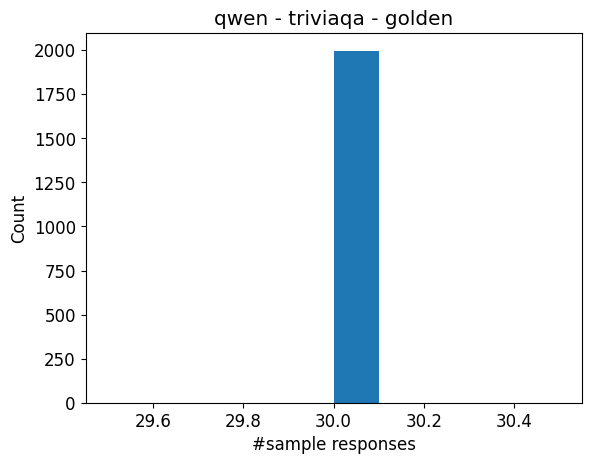

qwen - triviaqa - irrelevant: [(30, 1997)]


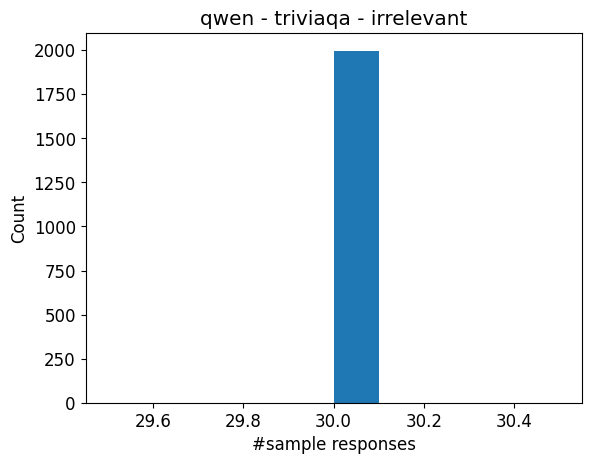

qwen - triviaqa - without: [(30, 1997)]


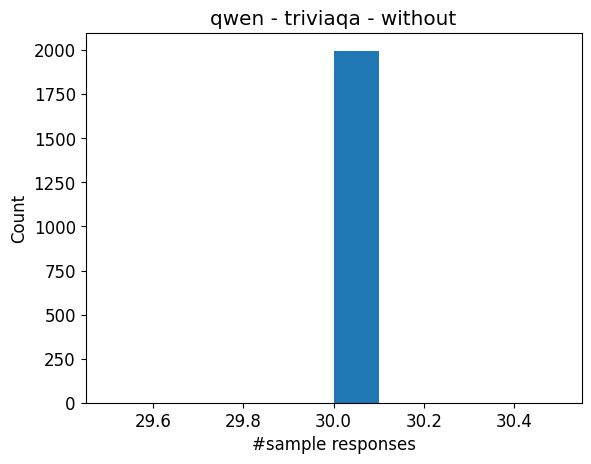

qwen - triviaqa - golden: [(1, 1326), (2, 159), (3, 106), (4, 86), (5, 72), (6, 57), (7, 45), (8, 35), (9, 33), (10, 20)]


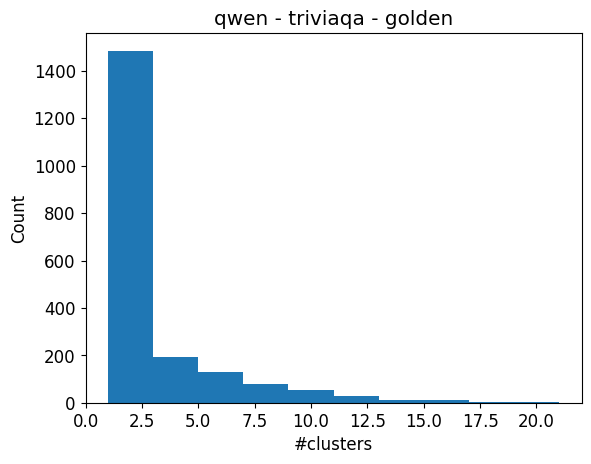

qwen - triviaqa - irrelevant: [(1, 318), (3, 196), (4, 188), (5, 182), (6, 175), (7, 168), (2, 160), (8, 127), (9, 104), (10, 74)]


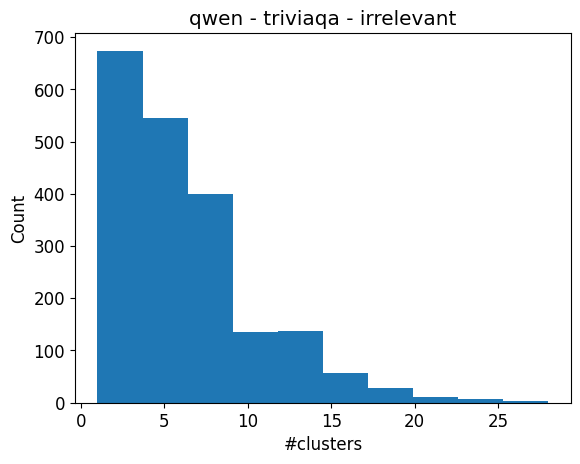

qwen - triviaqa - without: [(1, 1122), (2, 221), (3, 112), (4, 72), (5, 65), (6, 57), (7, 48), (8, 45), (10, 37), (9, 33)]


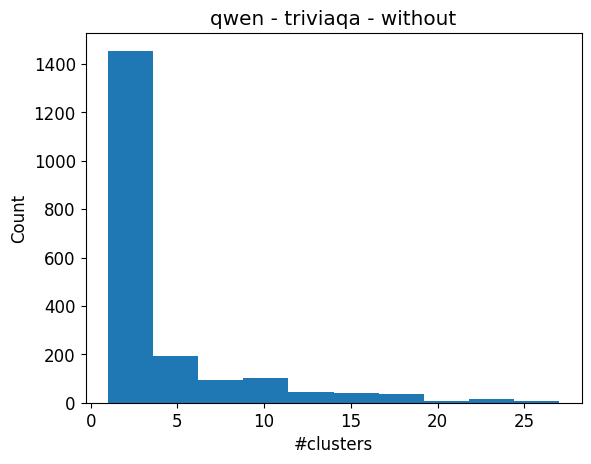

qwen - triviaqa - golden: [(-0.0, 1326), (0.24493002679463532, 17), (0.6909233093138181, 15), (0.1461447460085638, 15), (0.39267446722755217, 14), (0.45056120886630463, 13), (0.6571577614973405, 12), (0.3250829733914482, 12), (0.6842317651303003, 12), (0.6730116670092565, 9)]


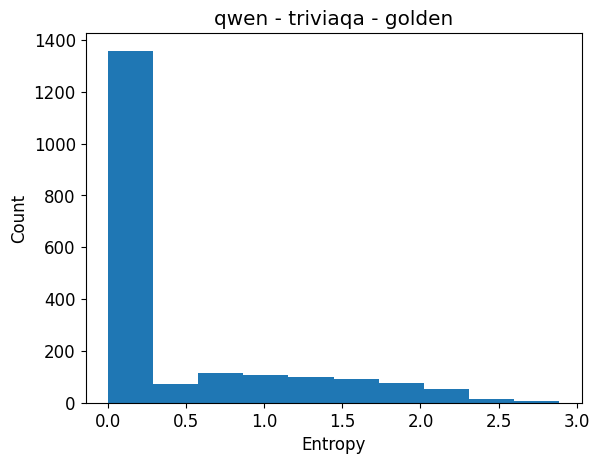

qwen - triviaqa - irrelevant: [(-0.0, 318), (0.1461447460085638, 19), (0.45056120886630463, 17), (0.24493002679463532, 16), (0.5004024235381879, 16), (0.3250829733914482, 14), (0.39267446722755217, 12), (0.6842317651303003, 11), (0.3887343902209295, 10), (0.6108643020548934, 9)]


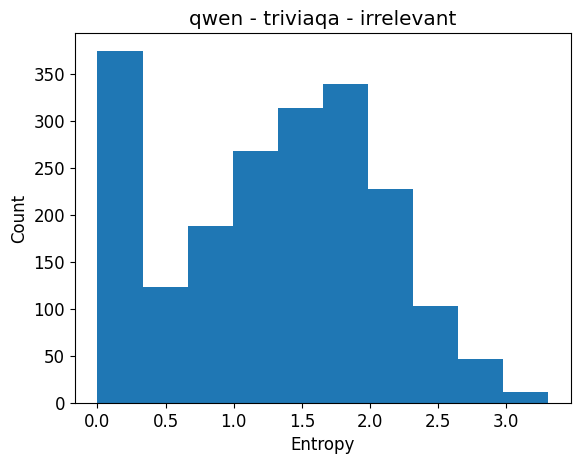

qwen - triviaqa - without: [(-0.0, 1122), (0.5004024235381879, 26), (0.1461447460085638, 25), (0.6365141682948128, 17), (0.45056120886630463, 17), (0.5432727813369008, 16), (0.39267446722755217, 16), (0.5799151714181009, 16), (0.3250829733914482, 14), (0.6108643020548934, 14)]


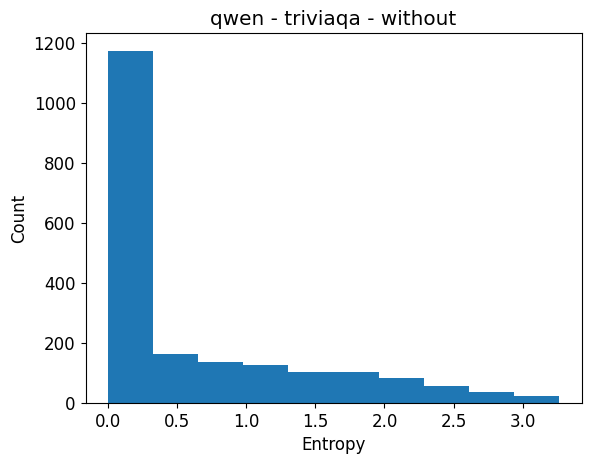

qwen - triviaqa - golden: [(1.0, 1641), (0.0, 356)]


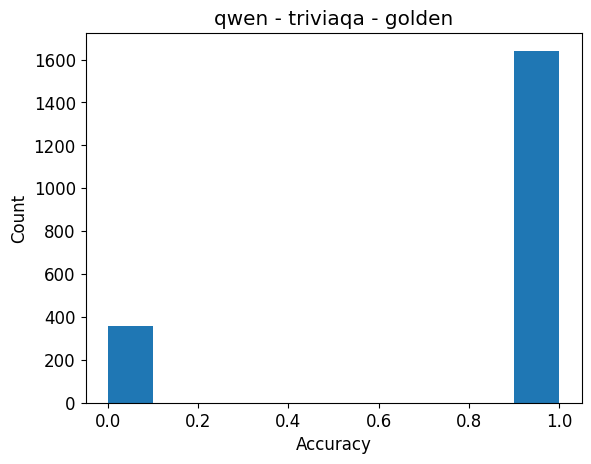

qwen - triviaqa - irrelevant: [(0.0, 1156), (1.0, 841)]


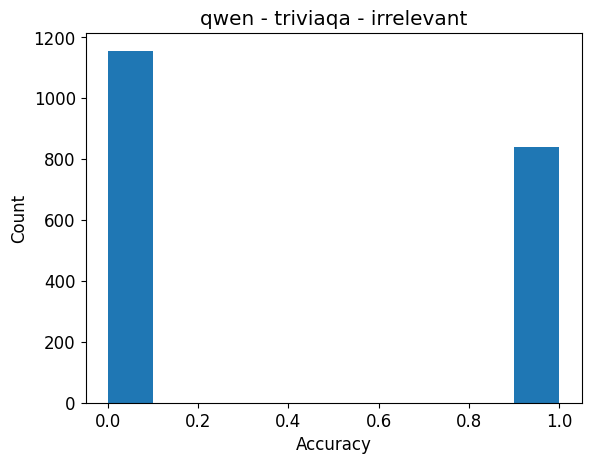

qwen - triviaqa - without: [(1.0, 1236), (0.0, 761)]


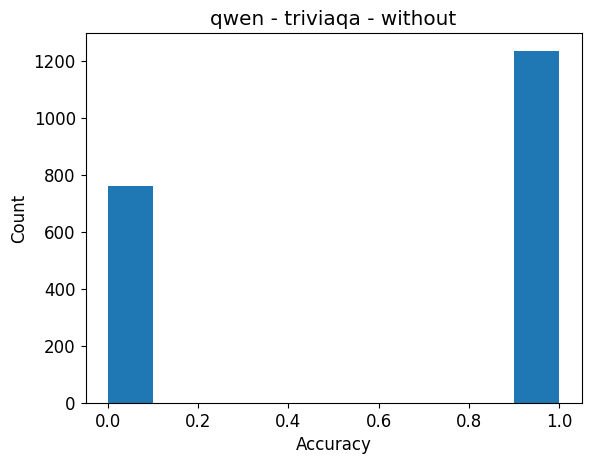

In [6]:
data = load_pickle_file("output/data/qwen-triviaqa.pkl")
print_data_info(data)

Meta: 
{
  "model": "Qwen/Qwen2.5-7B-Instruct",
  "dataset": "bioasq",
  "dataset_json_file": "dataset/json/bioasq_train_2000.json"
}
Total items: 2000


Checking: 100%|██████████| 2000/2000 [00:00<00:00, 258341.54it/s]

Valid: 1997, Invalid: 3
First item: 
{
  "example": {
    "id": "56bc751eac7ad10019000013",
    "context": "<context>Acrokeratosis paraneoplastica of Bazex is a rare but important paraneoplastic dermatosis, usually manifesting as psoriasiform rashes over the acral sites.</context>\n<context>[Paraneoplastic palmoplantar hyperkeratosis. Minor form of acrokeratosis neoplastica Bazex?].</context>\n<context>Acrokeratosis paraneoplastica Bazex is a rare, obligate paraneoplasia initially presenting with palmoplantar hyperkeratosis. </context>\n<context>We diagnosed a minor form of acrokeratosis paraneoplastica Bazex. </context>\n<context>Acrokeratosis paraneoplastica (Bazex syndrome): report of a case associated with small cell lung carcinoma and review of the literature.</context>\n<context>Acrokeratosis paraneoplastic (Bazex syndrome) is a rare, but distinctive paraneoplastic dermatosis characterized by erythematosquamous lesions located at the acral sites and is most commonly associated wi

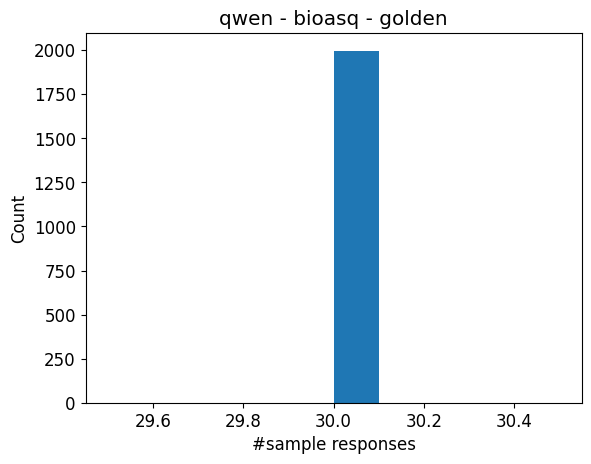

qwen - bioasq - irrelevant: [(30, 1997)]


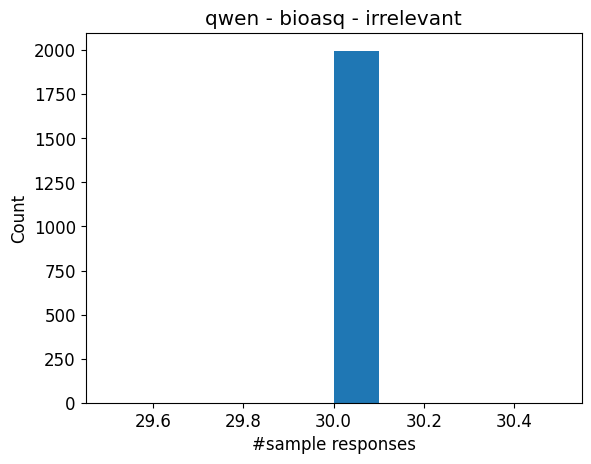

qwen - bioasq - without: [(30, 1997)]


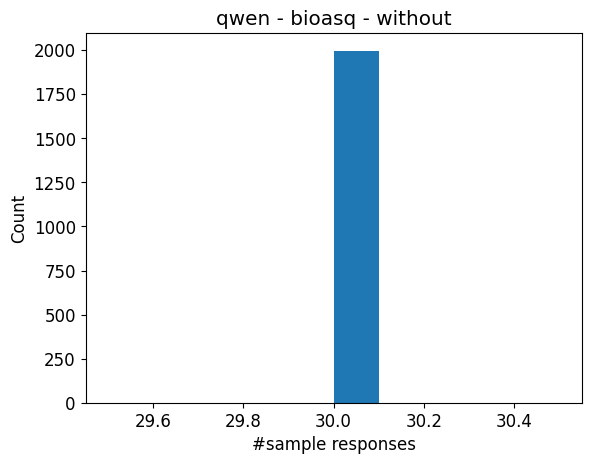

qwen - bioasq - golden: [(1, 1048), (2, 194), (3, 166), (4, 111), (5, 98), (6, 82), (7, 67), (8, 60), (9, 51), (10, 43)]


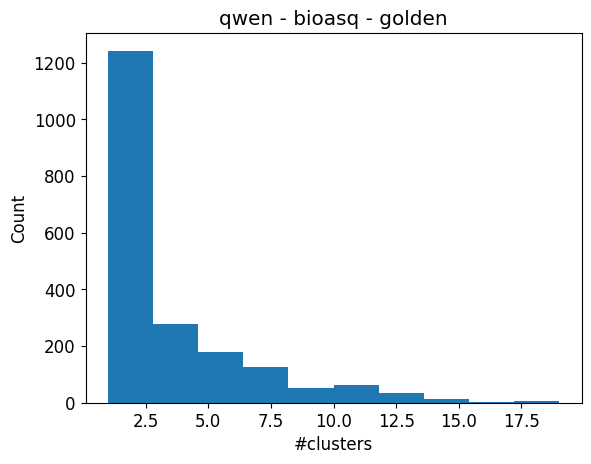

qwen - bioasq - irrelevant: [(4, 295), (3, 292), (2, 245), (5, 224), (1, 219), (7, 160), (6, 159), (8, 121), (9, 75), (10, 56)]


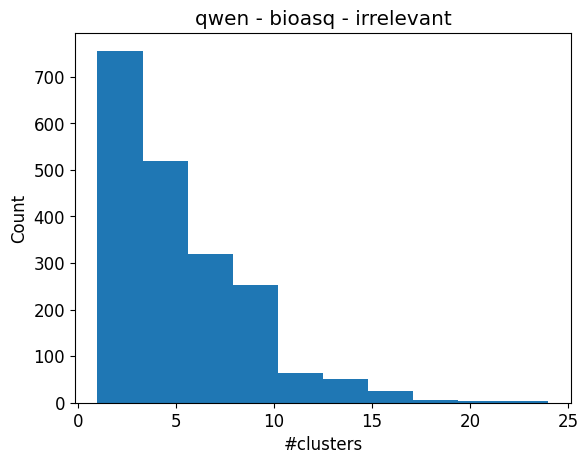

qwen - bioasq - without: [(1, 936), (2, 301), (3, 181), (4, 121), (5, 107), (6, 64), (7, 51), (8, 47), (9, 37), (12, 26)]


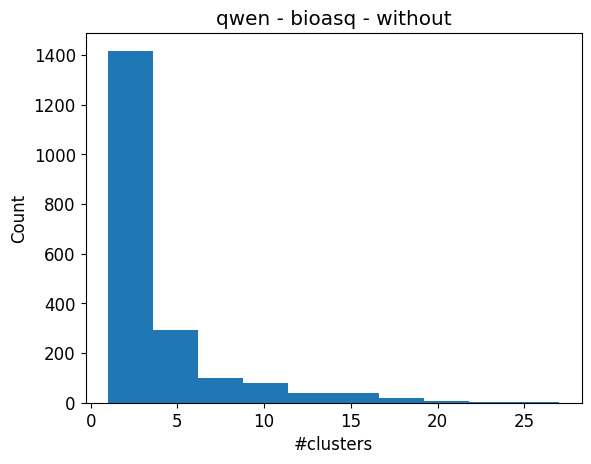

qwen - bioasq - golden: [(-0.0, 1048), (0.1461447460085638, 19), (0.6365141682948128, 16), (0.24493002679463532, 16), (0.3250829733914482, 16), (0.45056120886630463, 15), (0.6571577614973405, 14), (0.5799151714181009, 14), (0.5432727813369008, 13), (0.6108643020548934, 12)]


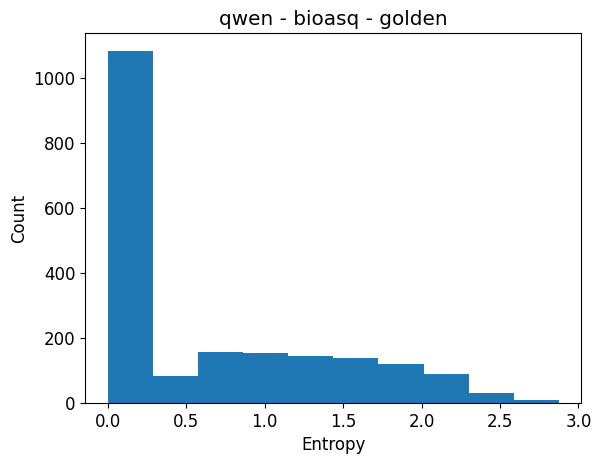

qwen - bioasq - irrelevant: [(-0.0, 219), (0.6909233093138181, 23), (0.6365141682948128, 23), (0.6571577614973405, 21), (0.5432727813369008, 19), (0.3250829733914482, 19), (0.5004024235381879, 19), (0.39267446722755217, 16), (0.24493002679463532, 16), (0.6730116670092565, 16)]


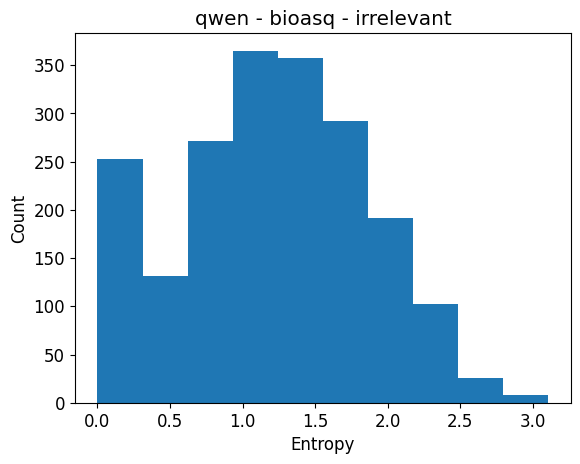

qwen - bioasq - without: [(-0.0, 936), (0.6909233093138181, 29), (0.6108643020548934, 27), (0.6365141682948128, 27), (0.1461447460085638, 25), (0.6842317651303003, 23), (0.24493002679463532, 23), (0.5432727813369008, 22), (0.5799151714181009, 21), (0.3250829733914482, 18)]


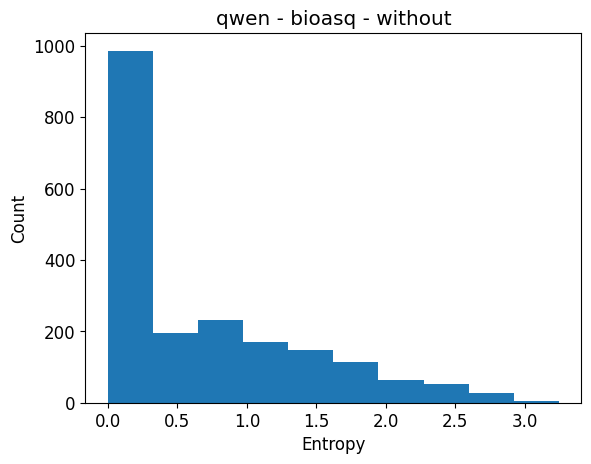

qwen - bioasq - golden: [(1.0, 1734), (0.0, 263)]


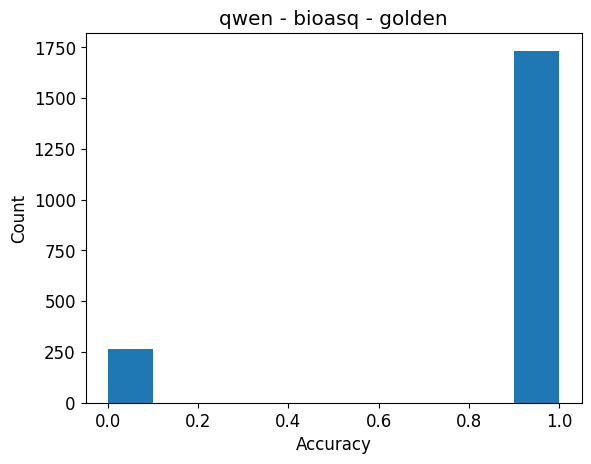

qwen - bioasq - irrelevant: [(0.0, 1725), (1.0, 272)]


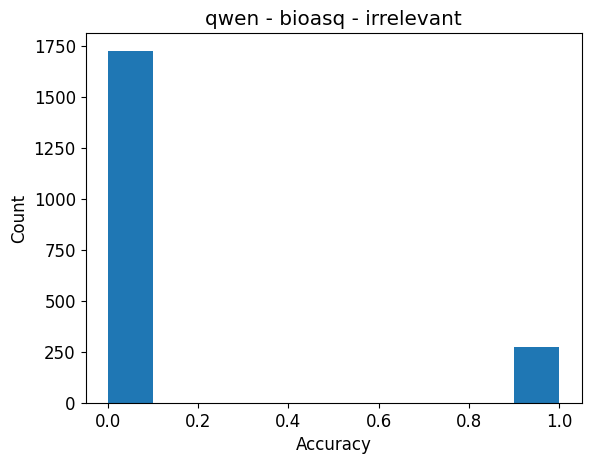

qwen - bioasq - without: [(1.0, 1159), (0.0, 838)]


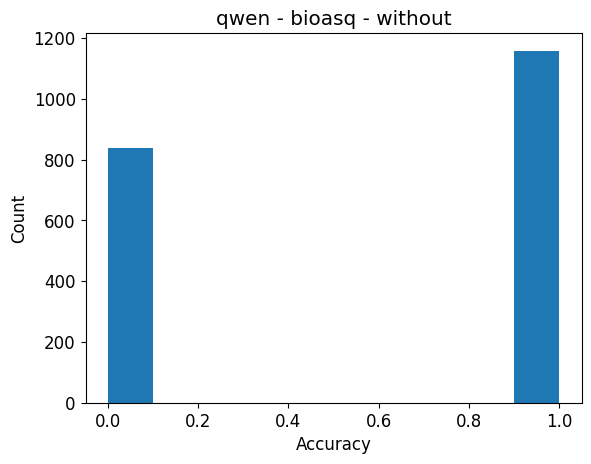

In [7]:
data = load_pickle_file("output/data/qwen-bioasq.pkl")
print_data_info(data)